In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
import numpy as np

import os
import sys

import pandas as pd

In [3]:
savedir = "./saved-outputs/inertia_basic1.0_equiv0.0001/"
full_df = pd.read_pickle(savedir + "inertia_loss_log.pkl")
mod = pd.read_pickle(savedir + "modifiedinertia_loss_log.pkl")


cols = ["trial", "epoch", "train_mse", "test_mse", "equiv_err"]
full_df.columns = cols
mod.columns = cols
full_df['logvan'] = np.log(full_df['equiv_err'])
full_df['logmod'] = np.log(mod['equiv_err'])

## Plot

In [4]:
from joypy import joyplot

In [5]:
temp_df = full_df[full_df['epoch'].isin([5, 15, 30])]

In [6]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

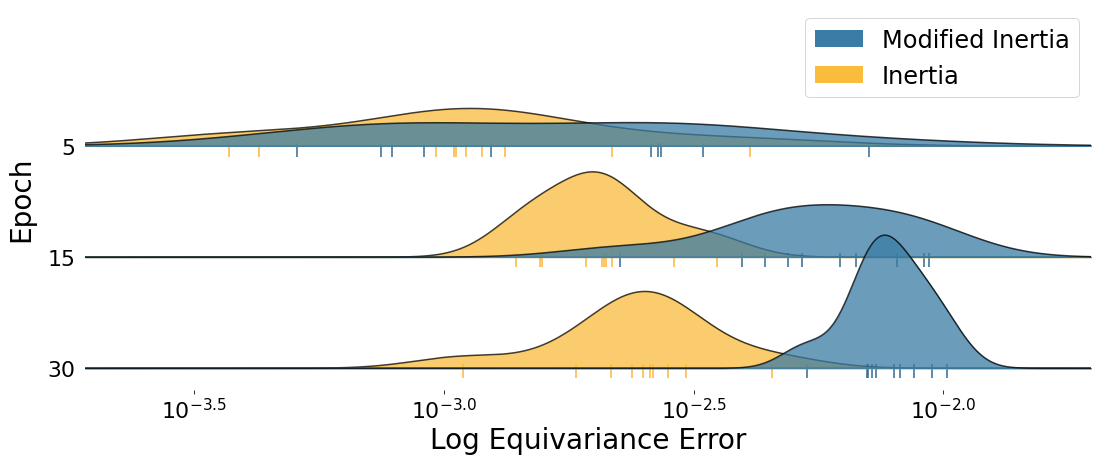

In [15]:
fs = 24

colors = ["#fabc3c","#ffb238","#3a7ca5","#2f6690"]

fig, axes = joyplot(
    data=temp_df[['epoch', 'logmod', 'logvan']], 
    by='epoch',
    column=['logvan', 'logmod'],
    color=[colors[0], colors[2]],
    legend=True,
    alpha=0.75,
    figsize=(15, 6),
#     xlabel="Log Equivariance Error",
    xlabelsize=fs-2,
#     ylabel="Epoch",
    ylabelsize=fs-2
)


colors = ["#fabc3c","#ffb238","#3a7ca5","#2f6690"]


temp = temp_df[temp_df['epoch']==5]
hghts = [10.8, 5.3, -0.25]
plt.scatter(temp['logvan'],np.zeros(temp.shape[0])+hghts[0], marker='|', s=200,
           c=colors[1])
plt.scatter(temp['logmod'],np.zeros(temp.shape[0])+hghts[0], marker='|', s=200,
           c=colors[3])

temp = temp_df[temp_df['epoch']==15]
plt.scatter(temp['logvan'],np.zeros(temp.shape[0])+hghts[1], marker='|', s=200,
           c=colors[1])
plt.scatter(temp['logmod'],np.zeros(temp.shape[0])+hghts[1], marker='|', s=200,
           c=colors[3])


temp = temp_df[temp_df['epoch']==30]
plt.scatter(temp['logvan'],np.zeros(temp.shape[0])+hghts[2], marker='|', s=200,
           c=colors[1])
plt.scatter(temp['logmod'],np.zeros(temp.shape[0])+hghts[2], marker='|', s=200,
           c=colors[3])


plt.ylim(-1.2, 18)

patches = [Patch(facecolor=colors[0], edgecolor=None,
                         label="Inertia"),
           Patch(facecolor=colors[2], edgecolor=None,
                         label="Modified Inertia")][::-1]
           

axes[0].legend(handles=patches, fontsize=fs)
axes[-1].set_xlabel("Log Equivariance Error", fontsize=fs+4)
axes[-1].xaxis.set_visible(True)
axes[-1].set_xticks([-3.5, -3, -2.5, -2.])
axes[-1].set_xticklabels([r"$10^{-3.5}$", r"$10^{-3.0}$", r"$10^{-2.5}$", r"$10^{-2.0}$"])
axes[-1].set_ylabel("Epoch", fontsize=fs+4, labelpad=50)
axes[-1].set_yticks([])
axes[-1].yaxis.set_visible(True)
plt.savefig("./posterior_sample.pdf", bbox_inches='tight')
# fig.ylabel("Epoch")

In [7]:
temp_df

,trial,epoch,train_mse,test_mse,equiv_err,logvan,logmod
1,0,5,20.489899,18.428383,0.051021,-2.975525,-3.293703
3,0,15,8.031392,7.770485,0.066216,-2.714837,-2.357364
6,0,30,6.532228,6.497185,0.069595,-2.665057,-2.085743
12,1,5,8.646666,8.734535,0.032358,-3.430907,-2.480931
14,1,15,6.756063,7.409523,0.068883,-2.675341,-2.311202
17,1,30,6.073295,6.556208,0.075614,-2.582119,-2.149926
23,2,5,16.315058,17.708696,0.048946,-3.017032,-2.564448
25,2,15,6.973575,8.348866,0.086013,-2.453260,-2.174842
28,2,30,6.021878,7.144441,0.077985,-2.551240,-2.097896
34,3,5,9.554076,9.954782,0.050838,-2.979111,-3.040331


In [12]:
temp

,trial,epoch,train_mse,test_mse,equiv_err,logvan,logmod
1,0,5,20.489899,18.428383,0.051021,-2.975525,-3.293703
12,1,5,8.646666,8.734535,0.032358,-3.430907,-2.480931
23,2,5,16.315058,17.708696,0.048946,-3.017032,-2.564448
34,3,5,9.554076,9.954782,0.050838,-2.979111,-3.040331
45,4,5,22.367958,24.581264,0.051989,-2.956718,-2.905171
56,5,5,8.714399,8.992849,0.056218,-2.878517,-2.584614
67,6,5,15.534724,13.974588,0.091810,-2.388039,-2.571768
78,7,5,11.990459,11.354609,0.034394,-3.369873,-3.126738
89,8,5,8.390474,9.267990,0.053730,-2.923777,-3.104893
100,9,5,18.402634,17.676823,0.069671,-2.663976,-2.148876


In [60]:
ax[0].legend()